단계
1. Module import
2. 딥러닝 모델을 설계할 때 활용하는 장비 확인
3. CIFAR10 데이터 다운로드(Train,Test set 분리하기)
4. 데이터 확인하기
5. CNN모델 설계
6. Optimizer, Objective Function 설정
7. CNN 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
8. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
9. CNN 학습 실행, Train& Test set의 Loss 및 Test set Accuracy 확인하기

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
if torch.cuda.is_available():
  DEVICE=torch.device('cuda')
else:
  DEVICE=torch.device('cpu')
print('Using PyTorch version:',torch.__version__, 'Device:',DEVICE)

Using PyTorch version: 1.8.1+cu101 Device: cpu


In [ ]:
BATCH_SIZE=32
EPOCHS=10

In [ ]:
train_dataset=datasets.CIFAR10(root='../data/CIFAR_10',
                               train=True,
                               download=True,
                               transform=transforms.ToTensor())
test_dataset=datasets.CIFAR10(root='../data/CIFAR_10',
                              train=True,
                              transform=transforms.ToTensor())
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)


Extracting ../data/CIFAR_10/cifar-10-python.tar.gz to ../data/CIFAR_10


In [ ]:
for (X_train,y_train) in train_loader:
  print('X_train:',X_train.size(),'type:',X_train.type())
  print('y_train:',y_train.size(),'type:',y_train.type())
  break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


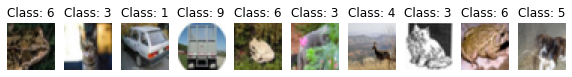

In [ ]:
pltsize=1
plt.figure(figsize=(10*pltsize,pltsize))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.axis('off')
  plt.imshow(np.transpose(X_train[i],(1,2,0)))
  plt.title('Class: '+str(y_train[i].item()))

In [ ]:
class CNN(nn.Module):
  def __init__(self):
      super(CNN,self).__init__()

      self.conv1=nn.Conv2d(in_channels=3,
                           out_channels=8,
                           kernel_size=3,
                           padding=1)
      self.conv2=nn.Conv2d(in_channels=8,
                           out_channels=16,
                           kernel_size=3,
                           padding=1)
      self.pool=nn.MaxPool2d(kernel_size=2,
                             stride=2)
      
      self.fc1=nn.Linear(8*8*16,30)
      self.fc2=nn.Linear(30,60)
      self.fc3=nn.Linear(60,10)

  def forward(self,x):
      x=self.conv1(x)
      x=F.relu(x)
      x=self.pool(x)
      x=self.conv2(x)
      x=F.relu(x)
      x=self.pool(x)

      x=x.view(-1,8*8*16)
      x=self.fc1(x)
      x=F.relu(x)
      x=self.fc2(x)
      x=F.relu(x)
      x=self.fc3(x)
      x=F.log_softmax(x)
      return x
      

In [ ]:
model=CNN().to(DEVICE)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
criterion=nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=10, bias=True)
)


In [ ]:
def train(model,train_loader,optimizer,log_interval):
  model.train()
  for batch_idx,(image,label) in enumerate(train_loader):
    image=image.to(DEVICE)
    label=label.to(DEVICE)
    optimizer.zero_grad()
    output=model(image)
    loss=criterion(output,label)
    loss.backward()
    optimizer.step()

    if batch_idx%log_interval==0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Train Loss: {:.6f}'.format(epoch,
            batch_idx*len(image),
            len(train_loader.dataset),100.*batch_idx/len(train_loader),loss.item()))

In [ ]:
def evaluate(model,test_loader):
  model.eval()
  test_loss=0
  correct=0

  with torch.no_grad():
    for image,label in test_loader:
      image=image.to(DEVICE)
      label=label.to(DEVICE)
      output=model(image)
      test_loss+=criterion(output,label).item()
      prediction=output.max(1,keepdim=True)[1]
      correct+=prediction.eq(label.view_as(prediction)).sum().item()

  test_loss/=(len(test_loader.dataset)/BATCH_SIZE)
  test_accuracy=100.*correct/len(test_loader.dataset)
  return test_loss,test_accuracy

In [ ]:
for epoch in range(1,EPOCHS+1):
  train(model,train_loader,optimizer,log_interval=200)
  test_loss,test_accuracy=evaluate(model,test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/50000 (0%)]	 Train Loss: 1.341087
Train Epoch: 1 [6400/50000 (13%)]	 Train Loss: 1.371976
Train Epoch: 1 [12800/50000 (26%)]	 Train Loss: 1.506208
Train Epoch: 1 [19200/50000 (38%)]	 Train Loss: 1.446859
Train Epoch: 1 [25600/50000 (51%)]	 Train Loss: 1.438574
Train Epoch: 1 [32000/50000 (64%)]	 Train Loss: 1.410404
Train Epoch: 1 [38400/50000 (77%)]	 Train Loss: 1.421803
Train Epoch: 1 [44800/50000 (90%)]	 Train Loss: 0.986604

[EPOCH: 1], 	Test Loss: 1.3838, 	Test Accuracy: 49.86 % 

Train Epoch: 2 [0/50000 (0%)]	 Train Loss: 1.298989
Train Epoch: 2 [6400/50000 (13%)]	 Train Loss: 1.693694
Train Epoch: 2 [12800/50000 (26%)]	 Train Loss: 1.302385
Train Epoch: 2 [19200/50000 (38%)]	 Train Loss: 1.368883
Train Epoch: 2 [25600/50000 (51%)]	 Train Loss: 1.513068
Train Epoch: 2 [32000/50000 (64%)]	 Train Loss: 1.207228
Train Epoch: 2 [38400/50000 (77%)]	 Train Loss: 1.136571
Train Epoch: 2 [44800/50000 (90%)]	 Train Loss: 1.445728

[EPOCH: 2], 	Test Loss: 1.2728, 	Test Ac